
## Shoreline Transformational Adaptation: Forward Looking Nature-based Climate Resilience


America’s coastal communities and infrastructure are threatened by extreme weather events and climate
change is accentuating these impacts. The Commonwealth of Virginia has already been transformed by
chronic high tide flooding and coastal erosion. Our proposed vision for a Shoreline Transformational
Adaptation brings together a unique team of Mason researchers to support the development of the next
generation of forward-looking, nature-inspired, coastal protection systems, integrating key Mason research
initiatives towards adapting our coastlines and communities to live with more water. Our proposed
framework recognizes the fundamental need for innovation and entrepreneurship to create the next
generation of nature-inspired innovative coastal protection systems provided by the RISE Rural and Urban
Coastal Community Resilience Challenge projects. To support this effort, the Mason Flood Hazards
Research Lab, the Center for Ocean-Land-Atmosphere Studies and the Business for a Better World Center
will: 1) develop engineering and scientific validation of the RISE innovative solutions providing the
foundation for widespread implementation for coastal protection at scale; 2) provide support for a forwardlooking design strategy ensuring that the proposed alternatives are resilient to extreme events and future
climate conditions; and 3) provide support to translate pilot studies to a greater market and communities
and to mitigate barriers related to social acceptance and adoption.

In [3]:
import warnings
warnings.filterwarnings("ignore")

import pathlib as pl;            import numpy as np
import netCDF4 as nc4;           import pandas as pd
import matplotlib.pyplot as plt; import xarray as xr
import json;                     import requests
import plotly.graph_objs as go;  import matplotlib as mpl
import geopandas as gpd;         from datetime import timedelta, datetime
from random import randint
from sklearn.neighbors import BallTree
from shapely import Polygon,Point,LineString
from matplotlib.lines import Line2D

---
### ADCP Marsh

In [4]:
root = pl.Path('C:/Users/decar/OneDrive - George Mason University - O365 Production/fall_24/Independent_Study/Seagrant_Prj/Data/Marsh')
stations = gpd.read_file(root / 'field' / 'marsh_11' / 'Points_111023_Sensors.shp')

stations

,Name,Descriptio,Layer,FeatureCod,Easting,Northing,Elevation,GlobalLati,GlobalLong,GlobalElli,LocalLatit,LocalLongi,LocalEllip,H_Prec_Obs,V_Prec_Obs,Date_Obs,Time_Obs,geometry
0,2001,GMU12,Points,None,3.683597e+06,1.112001e+06,0.077401,0.651434,-1.333925,-35.706727,37.324431,-76.428269,-35.706689,0.011488,0.019156,11/10/2023,11:56:38 AM,POINT Z (3683597.107 1112001.321 0.077)
1,2002,GMU9,Points,None,3.683598e+06,1.111994e+06,-1.835189,0.651433,-1.333925,-37.619449,37.324369,-76.428263,-37.619410,0.011892,0.019484,11/10/2023,11:59:04 AM,POINT Z (3683597.784 1111994.496 -1.835)
2,2003,GMU8,Points,None,3.683563e+06,1.111941e+06,-0.519140,0.651425,-1.333932,-36.303163,37.323896,-76.428669,-36.303125,0.013388,0.021329,11/10/2023,12:02:52 PM,POINT Z (3683562.903 1111941.251 -0.519)
3,2004,GMU6?,Points,None,3.683561e+06,1.111943e+06,-0.309012,0.651425,-1.333932,-36.092938,37.323910,-76.428695,-36.092900,0.013371,0.021211,11/10/2023,12:03:28 PM,POINT Z (3683560.598 1111942.754 -0.309)
4,2005,GMU11,Points,None,3.683554e+06,1.111943e+06,-0.464837,0.651425,-1.333934,-36.248560,37.323915,-76.428766,-36.248521,0.013284,0.020956,11/10/2023,12:04:12 PM,POINT Z (3683554.267 1111943.077 -0.465)
5,2006,ADCP,Points,None,3.683571e+06,1.111844e+06,-2.154853,0.651410,-1.333931,-37.940698,37.323019,-76.428603,-37.940660,0.014207,0.022903,11/10/2023,12:09:39 PM,POINT Z (3683570.913 1111844.041 -2.155)
6,2007,GMU 1,Points,None,3.683561e+06,1.111854e+06,-0.960532,0.651411,-1.333933,-36.745904,37.323107,-76.428716,-36.745866,0.014179,0.023408,11/10/2023,12:10:44 PM,POINT Z (3683560.712 1111853.572 -0.961)
7,2008,GMU2,Points,None,3.683558e+06,1.111855e+06,-0.765672,0.651411,-1.333933,-36.550940,37.323120,-76.428745,-36.550902,0.014060,0.023173,11/10/2023,12:11:09 PM,POINT Z (3683558.136 1111854.989 -0.766)
8,2009,GMU4,Points,None,3.683556e+06,1.111856e+06,0.053785,0.651412,-1.333934,-35.731404,37.323132,-76.428765,-35.731366,0.014485,0.023028,11/10/2023,12:11:38 PM,POINT Z (3683556.265 1111856.244 0.054)
9,2010,GMU5,Points,None,3.683545e+06,1.111868e+06,0.089081,0.651413,-1.333936,-35.695574,37.323236,-76.428889,-35.695536,0.014281,0.023409,11/10/2023,12:12:28 PM,POINT Z (3683545.026 1111867.522 0.089)


1/hx = 1/h0 + a(x - x0)    
a = (1/hx -1/h0)/(x-x0)

In [6]:
def point_lookup(model_lat:np.array, model_lon:np.array, satellite_lat:np.array, satellite_lon:np.array):
    tree = BallTree(np.deg2rad(np.c_[model_lat,model_lon]), metric='haversine')
    distances, indices = tree.query(np.deg2rad(np.c_[satellite_lat, satellite_lon]), k = 1)
    return distances*6371,indices


def datenum_to_datetime(datenum):
    """
    Convert Matlab datenum into Python datetime.
    :param datenum: Date in datenum format
    :return:        Datetime object corresponding to datenum.
    """
    if datenum < 1:
        temp = np.nan
    else:
        days = datenum % 1
        hours = days % 1 * 24
        minutes = hours % 1 * 60
        seconds = minutes % 1 * 60
        temp = datetime.fromordinal(int(datenum)) \
               + timedelta(days=int(days)) \
               + timedelta(hours=int(hours)) \
               + timedelta(minutes=int(minutes)) \
               + timedelta(seconds=round(seconds)) \
               - timedelta(days=366)
    return temp

In [8]:
water = xr.open_dataset(root / 'field' / 'marsh' / 'GMU01.nc')
dtw,dto,dtm,dtm1 = [],[],[],[]
for i in range(len(water['Time'].data)):
    dtw.append(datenum_to_datetime(water['Time'].data[i]))
oyster= xr.open_dataset(root / 'field' / 'marsh' / 'GMU02.nc')
for i in range(len(oyster['Time'].data)):
    dto.append(datenum_to_datetime(oyster['Time'].data[i]))
marsh = xr.open_dataset(root / 'field' / 'marsh' / 'GMU05.nc')
for i in range(len(marsh['Time'].data)):
    dtm.append(datenum_to_datetime(marsh['Time'].data[i]))
marsh1 = xr.open_dataset(root / 'field' / 'marsh' / 'GMU04.nc')
for i in range(len(marsh1['Time'].data)):
    dtm1.append(datenum_to_datetime(marsh1['Time'].data[i]))

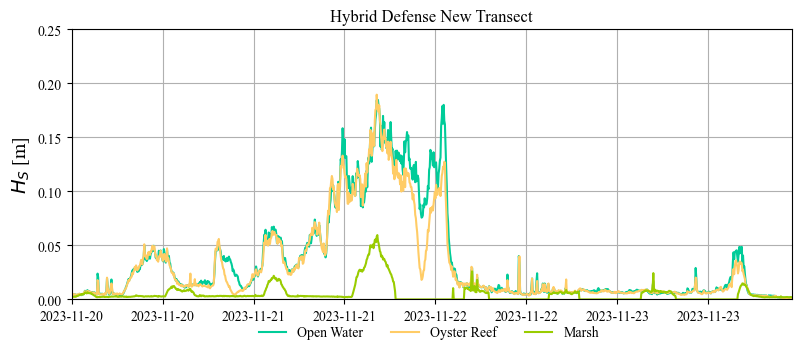

In [9]:
plt.rcParams["font.family"] = "Times New Roman"
fig = plt.figure(figsize=(8,3))
colors = ['#00cc99','#ffcc66','#99cc00']
ax = plt.axes([0,0.,0.9,.9])

ax.plot(dtw,water['Hs'].data,label='Open Water',color=colors[0])
ax.plot(dto,oyster['Hs'].data,label='Oyster Reef',color=colors[1])
ax.plot(dtm,marsh['Hs'].data,label='Marsh',color=colors[2])

ax.set_ylabel(r'$H_{S}$ [m]',fontsize=14)
ax.set_ylim([-.00001,0.25000001])
dt1 = pd.to_datetime('2023-11-20')
dt2 = pd.to_datetime('2023-11-23 23:00')
ax.set_xlim([dt1,dt2])
ax.grid(True)
ax.legend(loc='upper right', bbox_to_anchor=(0.75, -.05),ncol=3,frameon=False,fontsize=10)
ax.set_title('Hybrid Defense New Transect')
ax.xaxis.set_major_locator(plt.MaxNLocator(8))
#plt.savefig(f'/Users/tmiesse/work/FHRL/seagrant/field/waves/figures/timeseries_new_transect.png',dpi=480,bbox_inches='tight',pad_inches=0.1,transparent=True)
plt.show()

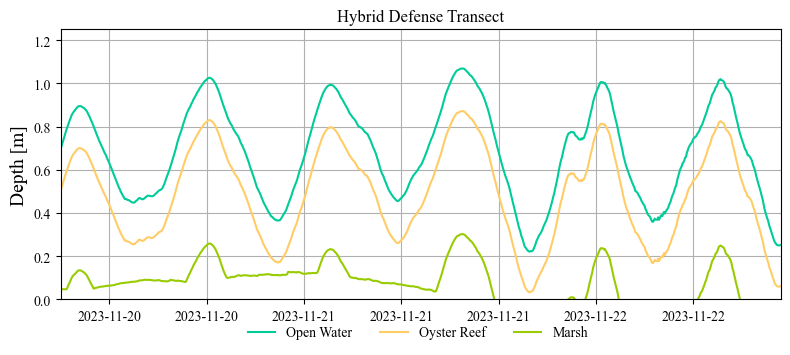

In [10]:
plt.rcParams["font.family"] = "Times New Roman"
fig = plt.figure(figsize=(8,3))
colors = ['#00cc99','#ffcc66','#99cc00']
ax = plt.axes([0,0.,0.9,.9])

ax.plot(dtw,water['depth'].data,label='Open Water',color=colors[0])
ax.plot(dto,oyster['depth'].data,label='Oyster Reef',color=colors[1])
ax.plot(dtm,marsh['depth'].data,label='Marsh',color=colors[2])

ax.set_ylabel(r'Depth [m]',fontsize=14)
ax.set_ylim([-.00001,1.25000001])
dt1 = pd.to_datetime('2023-11-20')
dt2 = pd.to_datetime('2023-11-22 23:00')
ax.set_xlim([dt1,dt2])
ax.grid(True)
ax.legend(loc='upper right', bbox_to_anchor=(0.75, -.05),ncol=3,frameon=False,fontsize=10)
ax.set_title('Hybrid Defense Transect')
ax.xaxis.set_major_locator(plt.MaxNLocator(8))
#plt.savefig(f'/Users/tmiesse/work/FHRL/seagrant/field/waves/figures/timeseries.png',dpi=480,bbox_inches='tight',pad_inches=0.1,transparent=True)
plt.show()

In [11]:
olat,olon = stations['LocalLatit'][6],stations['LocalLongi'][6]
disto,ind = point_lookup(stations['LocalLatit'][7],stations['LocalLongi'][7],olat,olon)
distm,ind = point_lookup(stations['LocalLatit'][9],stations['LocalLongi'][9],olat,olon)
distm1,ind= point_lookup(stations['LocalLatit'][8],stations['LocalLongi'][8],olat,olon)
eleo = stations['Elevation'][7]
elem = stations['Elevation'][9]
elem1 = stations['Elevation'][8]

In [12]:
dt1,dt2 = pd.to_datetime('2023-11-21 10:00'),pd.to_datetime('2023-11-22 06:00')
idx = np.where((dt1 < np.array(dtw)) &\
               (np.array(dtw) < dt2) &\
                (water['depth'].data>0.05))[0]
ido = np.where((oyster['depth'].data<0.45))[0]#&(oyster['Hs'].data ==np.max(oyster['Hs'].data)))[0]
id2oyster = np.intersect1d(idx,ido)
dt1,dt2 = pd.to_datetime('2023-11-21 10:00'),pd.to_datetime('2023-11-22 06:00')
idx = np.where((dt1 < np.array(dtw)) &\
               (np.array(dtw) < dt2) &\
                (water['depth'].data>0.05))[0]
idm = np.where((marsh['depth'].data>0.1))[0]#&(marsh['Hs'].data==np.max(marsh['Hs'].data)))[0]
id2marsh = np.intersect1d(idx,idm)

alpha_oyster = ((1/oyster['Hs'].data[id2oyster])-(1/water['Hs'].data[id2oyster]))/(disto*1000)
alpha_marsh = ((1/marsh['Hs'].data[id2marsh])-(1/water['Hs'].data[id2marsh]))/((distm*1000)-disto*1000)

In [13]:
dt1,dt2 = pd.to_datetime('2023-11-21 10:00'),pd.to_datetime('2023-11-22 06:00')
idx = np.where((dt1 < np.array(dtw)) &\
               (np.array(dtw) < dt2) &\
                (water['depth'].data>0.05))[0]
idm = np.where((marsh['depth'].data>0.1))[0]#&(marsh['Hs'].data==np.max(marsh['Hs'].data)))[0]
id2marsh = np.intersect1d(idx,idm)

In [14]:

alpha_oyster = ((1/oyster['Hs'].data[id2oyster])-(1/water['Hs'].data[id2oyster]))/(disto*1000)
alpha_marsh = ((1/marsh['Hs'].data[id2marsh])-(1/water['Hs'].data[id2marsh]))/((distm*1000)-disto*1000)

In [15]:
from scipy.optimize import curve_fit
def func(x, a,b,c):
  return a * np.exp(-b * x) + c
  #return a * np.log(b * x) + c
  #return a / np.log(x)# + b
  #return -np.log(x)#+a

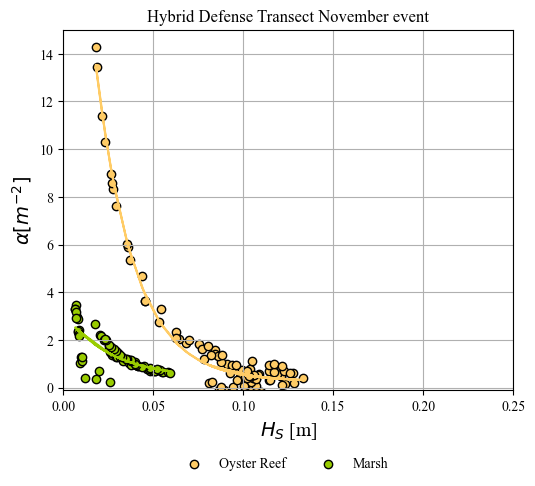

In [16]:
plt.rcParams["font.family"] = "Times New Roman"
fig = plt.figure(figsize=(5,4))
colors = ['#00cc99','#ffcc66','#99cc00']
ax = plt.axes([0,0.,0.9,.9])


ax.scatter(oyster['Hs'].data[id2oyster],alpha_oyster[0,:],label='Oyster Reef',color=colors[1],edgecolors='k')
line = np.poly1d(np.polyfit(oyster['Hs'].data[id2oyster],alpha_oyster[0,:],2))

popt, pcov = curve_fit(func, oyster['Hs'].data[id2oyster], alpha_oyster[0,:])
ax.plot(oyster['Hs'].data[id2oyster],func(oyster['Hs'].data[id2oyster], *popt),color=colors[1])

ax.scatter(marsh['Hs'].data[id2marsh],alpha_marsh[0,:],label='Marsh',color=colors[2],edgecolors='k')
popt, pcov = curve_fit(func, marsh['Hs'].data[id2marsh], alpha_marsh[0,:],maxfev=2000)

ax.plot(marsh['Hs'].data[id2marsh],func(marsh['Hs'].data[id2marsh], *popt),color=colors[2])

ax.set_ylabel(r'$ \alpha [m^{-2}]$',fontsize=14)
ax.set_xlabel(r'$H_{S}$ [m]',fontsize=14)
ax.set_ylim([-.1,15]),ax.set_xlim([-.00001,.25000001])

ax.grid(True)
ax.legend(loc='upper right', bbox_to_anchor=(0.75, -.15),ncol=3,frameon=False,fontsize=10)
ax.set_title('Hybrid Defense Transect November event')
#ax.xaxis.set_major_locator(plt.MaxNLocator(8))
#plt.savefig(f'/Users/tmiesse/work/FHRL/seagrant/field/waves/figures/coef_new_transect_dec.png',dpi=480,bbox_inches='tight',pad_inches=0.1,transparent=True)
plt.show()

In [17]:
dt1,dt2 = pd.to_datetime('2023-11-21 10:00'),pd.to_datetime('2023-11-22 01:00')
idx = np.where((dt1 < np.array(dtw)) &\
               (np.array(dtw) < dt2) &\
                (water['depth'].data>0.01))[0]
ido = np.where((oyster['depth'].data<0.85)&(oyster['depth'].data>0.075))[0]#&(oyster['Hs'].data ==np.max(oyster['Hs'].data)))[0]
id2oyster = np.intersect1d(idx,ido)
dt1,dt2 = pd.to_datetime('2023-11-21 10:00'),pd.to_datetime('2023-11-22 01:00')
idx = np.where((dt1 < np.array(dtw)) &\
               (np.array(dtw) < dt2) &\
                (water['depth'].data>0.01))[0]
idm = np.where((marsh['depth'].data<=0.5)&(marsh['depth'].data>0.11))[0]#&(marsh['Hs'].data==np.max(marsh['Hs'].data)))[0]
id2marsh = np.intersect1d(idx,idm)
idx = np.where((dt1 < np.array(dtw)) &\
               (np.array(dtw) < dt2) &\
                (water['depth'].data>0.01))[0]
idm = np.where((marsh1['depth'].data<=0.9)&(marsh1['depth'].data>0.11))[0]#&(marsh['Hs'].data==np.max(marsh['Hs'].data)))[0]
id2marsh1 = np.intersect1d(idx,idm)

alpha_oyster = ((1/oyster['Hs'].data[id2oyster])-(1/water['Hs'].data[id2oyster]))/(disto*1000)
alpha_marsh = ((1/marsh['Hs'].data[id2marsh])-(1/water['Hs'].data[id2marsh]))/((distm*1000))
alpha_marsh1 = ((1/marsh1['Hs'].data[id2marsh1])-(1/water['Hs'].data[id2marsh1]))/((distm1*1000))

In [18]:
alpha_oyster[alpha_oyster>5]=alpha_oyster[alpha_oyster>5]*.01
alpha_marsh[alpha_marsh>5]=alpha_marsh[alpha_marsh>5]*.01
alpha_marsh1[alpha_marsh1>5]=alpha_marsh1[alpha_marsh1>5]*.01

In [19]:
from scipy.optimize import curve_fit
def func(x, a,b,c):
  return a * np.exp(-b * x) + c
  #return a * np.log(b * x) + c
  #return a / np.log(x) + b
  #return -np.log(x)#+a

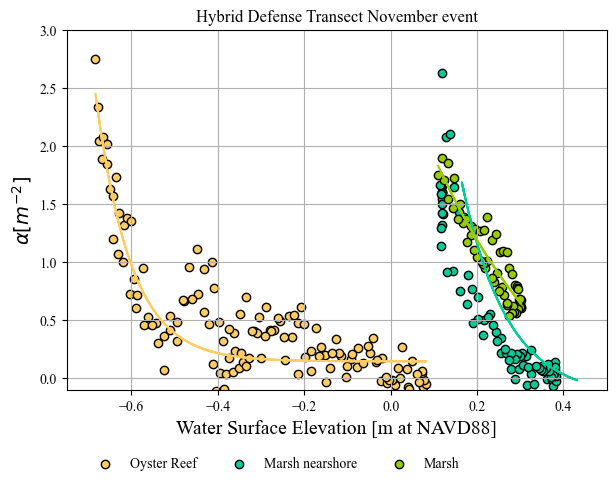

In [21]:
plt.rcParams["font.family"] = "Times New Roman"
fig = plt.figure(figsize=(6,4))
colors = ['#00cc99','#ffcc66','#99cc00']
ax = plt.axes([0,0.,0.9,.9])


ax.scatter(oyster['depth'].data[id2oyster]+eleo,alpha_oyster[0,:],label='Oyster Reef',color=colors[1],edgecolors='k')
popt, pcov = curve_fit(func, oyster['depth'].data[id2oyster]+eleo, alpha_oyster[0,:],maxfev=10000)
ax.plot(oyster['depth'].data[id2oyster]+eleo,func(oyster['depth'].data[id2oyster]+eleo, *popt),color=colors[1])

ax.scatter(marsh1['depth'].data[id2marsh1]+elem1-0.05,alpha_marsh1[0,:],label='Marsh nearshore',color=colors[0],edgecolors='k')
popt, pcov = curve_fit(func, marsh1['depth'].data[id2marsh1]+elem1-0.05, alpha_marsh1[0,:],maxfev=2000)
ax.plot(marsh1['depth'].data[id2marsh1]+elem1,func(marsh1['depth'].data[id2marsh1]+elem1-0.05, *popt),color=colors[0])

ax.scatter(marsh['depth'].data[id2marsh]+elem-0.09,alpha_marsh[0,:],label='Marsh',color=colors[2],edgecolors='k')
popt, pcov = curve_fit(func, marsh['depth'].data[id2marsh]+elem-0.09, alpha_marsh[0,:],maxfev=2000)
ax.plot(marsh['depth'].data[id2marsh]+elem-0.09,func(marsh['depth'].data[id2marsh]+elem-0.09, *popt),color=colors[2])

ax.set_ylabel(r'$ \alpha [m^{-2}]$',fontsize=14)
ax.set_xlabel(r'Water Surface Elevation [m at NAVD88]',fontsize=14)
ax.set_ylim([-.1,3]),ax.set_xlim([-.750001,.5000001])

ax.grid(True)
ax.legend(loc='upper right', bbox_to_anchor=(0.75, -.15),ncol=3,frameon=False,fontsize=10)
ax.set_title('Hybrid Defense Transect November event')
ax.xaxis.set_major_locator(plt.MaxNLocator(8))

plt.show()